# Example: Markowitz Strategy

In this example we will be using the **Static Market** model as well as the **Discrete Event Driven Simulation** (DEDS) egine.

The main idea behind the Markowitzz strategy is to distribute the value of the portfolio into a set of assets such that given a minimum expected return the variance of the return is minimized.

The underlying assumption here is that the returns of an asset can be modelled as a probability distribution with a constant mean and a constant covariance with the other assets.

Therefore an empirical estimation of the mean and the covariance matrix of each asset is calculated using a relevant timewindow in the past.

Notes: 
- Dataset A: This data contains Google and Apple stocks using data from Jan 1st 2017 until Jan 1st 2022.
- Dataset B: This dataset is formed by the top 5 most traded companies according to NASDAQ on the date, listed since 2016 from Jan 1st 2017 until Jan 1st 2022.


In [3]:
# Setup the dependencies
using Pkg; Pkg.add("Suppressor"); using Suppressor: @suppress;
@suppress Pkg.add(url="https://github.com/JuDO-dev/AirBorne.jl#dev");
@suppress Pkg.add(["Dates","Plots","DataFrames", "DirectSearch"]);

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


### DataSet A
This data contains Google and Apple stocks using data from Jan 1st 2017 until Jan 1st 2022.

In [10]:
using AirBorne.ETL.YFinance: get_interday_data
using Dates: DateTime,datetime2unix
# To generate this data use:
unix(x) = string(round(Int, datetime2unix(DateTime(x))))
dataA = get_interday_data(["AAPL","GOOG"], unix("2017-01-01"), unix("2022-01-01"))
first(dataA,4) # Display first 4 rows

Row,close,high,low,open,volume,date,unix,exchangeName,timezone,currency,symbol,assetID
,Float64,Float64,Float64,Float64,Int64,DateTime,Int64,String,String,String,String,String
1,29.0375,29.0825,28.69,28.95,115127600,2017-01-03T10:30:00,1483453800,NMS,America/New_York,USD,AAPL,NMS/AAPL
2,29.005,29.1275,28.9375,28.9625,84472400,2017-01-04T10:30:00,1483540200,NMS,America/New_York,USD,AAPL,NMS/AAPL
3,29.1525,29.215,28.9525,28.98,88774400,2017-01-05T10:30:00,1483626600,NMS,America/New_York,USD,AAPL,NMS/AAPL
4,29.4775,29.54,29.1175,29.195,127007600,2017-01-06T10:30:00,1483713000,NMS,America/New_York,USD,AAPL,NMS/AAPL


### DataSet B
This dataset is formed by the top 5 most traded companies according to NASDAQ on the date, listed since 2016 from Jan 1st 2017 until Jan 1st 2022.

In [7]:
########################################################
###    Pick the 5 most traded companies per sector   ###
########################################################
using AirBorne.ETL.NASDAQ: screener
using AirBorne.Utils: get_latest_N
using DataFrames: groupby, combine
tickers_df = screener()
filtered_df =tickers_df[[   x!="" ? parse(Int64, x)<2016 : false for x in tickers_df.ipoyear],["symbol","marketCap","sector","volume"]]
filtered_df[!,"volume"]=parse.(Int64,filtered_df[!,"volume"])
filtered_df[!,"marketCap"]=parse.(Float64,filtered_df[!,"marketCap"])
grouped_df = groupby(filtered_df,"sector")
f(sdf)= get_latest_N(sdf,:volume,5;rev=true)
result = combine(grouped_df,f)

#####################################################
###    Extract interday date from Yahoo Finance   ###
#####################################################
using AirBorne.ETL.YFinance: get_interday_data
using Dates: DateTime, datetime2unix
unix(x) = string(round(Int, datetime2unix(DateTime(x))))
dataB = get_interday_data(result.symbol, unix("2017-01-01"), unix("2022-01-01"))
first(dataB,4)  # Display first 4 rows

Row,close,high,low,open,volume,date,unix,exchangeName,timezone,currency,symbol,assetID
,Float64,Float64,Float64,Float64,Int64,DateTime,Int64,String,String,String,String,String
1,2.38,2.4,2.25,2.34,25500,2017-01-03T10:30:00,1483453800,NCM,America/New_York,USD,AEHR,NCM/AEHR
2,2.32,2.38,2.24,2.34,23300,2017-01-04T10:30:00,1483540200,NCM,America/New_York,USD,AEHR,NCM/AEHR
3,2.3,2.63,2.24,2.35,64100,2017-01-05T10:30:00,1483626600,NCM,America/New_York,USD,AEHR,NCM/AEHR
4,2.34,2.37,2.3,2.3,47800,2017-01-06T10:30:00,1483713000,NCM,America/New_York,USD,AEHR,NCM/AEHR


## Using the Markowitz Template

In [12]:
using AirBorne.Engines.DEDS: run
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data
using AirBorne.Strategies.Markowitz: initialize!, trading_logic!
using Dates: DateTime

my_expose_data(context,data) = expose_data(context,data; historical=false)
@time context = run(
    dataA,
    initialize!,
    trading_logic!,
    execute_orders!,
    my_expose_data;
    audit=true,
    max_date=DateTime(2022, 1, 1),
    verbose=true,
)
@info "done"

 24.143534 seconds (11.57 M allocations: 1.303 GiB, 8.58% gc time, 1.20% compilation time)


[ Info: done


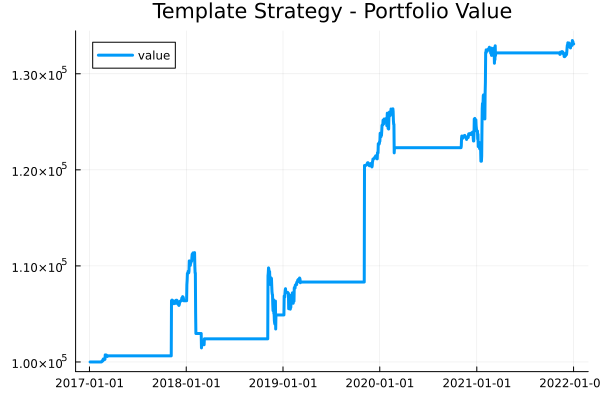

In [16]:
using AirBorne.Structures: summarizePerformance
using Plots: plot
results = summarizePerformance(dataA, context)
plot(results.date, results.dollarValue, title="Template Strategy - Portfolio Value", label="value", linewidth=3)

## Building your own Markowitz Strategy

In [18]:
using AirBorne.Utils: sortedStructInsert!
using AirBorne.Structures: ContextTypeA, TimeEvent
using AirBorne.Markets.StaticMarket: Order, place_order!
using AirBorne.ETL.AssetValuation: stockValuation, returns, covariance
using Dates: Day, year
using DataFrames: DataFrame, groupby, combine, mean, Not
using DotMaps: DotMap
using DirectSearch: 
    DSProblem, Optimize!, SetInitialPoint, SetObjective, SetIterationLimit, SetGranularity, AddExtremeConstraint, AddProgressiveConstraint
using Suppressor: @suppress;

function custom_initialize!(context::ContextTypeA; horizon::Real=30, initialCapital::Real=10^5, min_growth::Real=0.001)
    
    ###################################
    ####  Parameters & Structures  ####
    ###################################
    context.extra.horizon = horizon
    
    context.extra.valueHistory=DataFrame()
    context.extra.returnHistory=DataFrame()
    context.extra.currentValue=DataFrame()
    context.extra.pastValue=DataFrame()
    
    context.extra.idealPortfolioDistribution =[]
    context.extra.min_growth=min_growth
    
    ###################################
    ####  Specify Account Balance  ####
    ###################################
    context.accounts.usd = DotMap(Dict())
    context.accounts.usd.balance = initialCapital
    context.accounts.usd.currency = "USD"
    
    #########################################
    ####  Define first simulation event  ####
    #########################################
    # Define First Event (Assumming the first event starts from the data
    # The first even should be at least as long as the long horizon)
    next_event_date = context.current_event.date
    new_event = TimeEvent(next_event_date, "data_transfer")
    sortedStructInsert!(context.eventList, new_event, :date)
    return nothing
end


function custom_trading_logic!(context::ContextTypeA, data::DataFrame; tune_parameters::Dict=Dict())
    
    ########################################
    ####  Define next simulation event  ####
    ########################################
    next_event_date = context.current_event.date + Day(1)
    new_event = TimeEvent(next_event_date, "data_transfer")
    sortedStructInsert!(context.eventList, new_event, :date)
    
    #######################
    ####  Update data  ####
    #######################
    if size(data,1)==0 # No New data, nothing to do
        return nothing 
    end
    context.extra.pastValue=context.extra.currentValue
    context.extra.currentValue=stockValuation(data)
    [push!(context.extra.valueHistory,r) for r=eachrow(context.extra.currentValue)]
    
    if size(context.extra.pastValue,1)>0 # Add new data to history record
        r1 = returns(vcat(context.extra.pastValue,context.extra.currentValue))
        push!(context.extra.returnHistory,r1[end,:])
    end

    # 2.2 
    ################################
    ####  Calculate Statistics  ####
    ################################
    if size(context.extra.returnHistory,1)<context.extra.horizon
        return nothing # Not enough history data to 
    end
    d = context.extra.returnHistory[end-context.extra.horizon+1:end,:]
    M = covariance(d) # Covariance Matrix
    m = mean(Matrix(d[!,Not(["date","stockReturns"])]),dims=1)
    max_return,ix = findmax(m)
    
    ######################################
    ####  Solve Optimization problem  ####
    ######################################
    if max_return>context.extra.min_growth # Feasible problem
        if context.extra.idealPortfolioDistribution==[]
            initial_point = zeros(size(m))
            initial_point[ix]=1.0
        else
            initial_point = context.extra.idealPortfolioDistribution 
        end

        upper_cons(x) = all(x .<= 1) 
        lower_cons(x) = all(x .>= 0) 
        min_return(x) = context.extra.min_growth-(m*x)[1] # I want at least a 0.1% return in 1 day 
        obj(x) = x'*M*x 

        p = DSProblem(length(m))
        SetGranularity(p, Dict( [i => 0.001 for i=1:length(m)] ))
        SetObjective(p,obj)
        AddProgressiveConstraint(p, min_return)
        AddExtremeConstraint(p, upper_cons)
        AddExtremeConstraint(p, lower_cons)
        SetInitialPoint(p,vec([ i for i =initial_point]))
        @suppress Optimize!(p)
        context.extra.idealPortfolioDistribution = isnothing(p.x) ? zeros(size(m)) : p.x
    else
        context.extra.idealPortfolioDistribution = zeros(size(m)) # Sell absolutely everytihng. Market is going down.
    end
          
    #######################################################
    ####  Calculate Difference with Optimal Portfolio  ####
    #######################################################
    asset_names = names(context.extra.currentValue)[2:end-1]
    cv=reshape(Matrix(context.extra.currentValue)[2:end-1], (length(asset_names))) # Current value per share for ticker
    if length(context.portfolio)==0 # Obtain vector with current portfolio
        context.portfolio = Dict([name=>0.0 for name in names(context.extra.currentValue)][2:end-1])
    end
    currentPortfolio = reshape(Matrix(DataFrame(context.portfolio)), (length(asset_names)))
    total_capital = context.accounts.usd.balance + (currentPortfolio'*cv)[1] # Total capital to distribute 
    
    # Amount of shares to have of each ticker
    nextPortfolio =  reshape([context.extra.idealPortfolioDistribution[i] * total_capital / cv[i] for i=1:length(cv)], (length(asset_names)))
    
    # Amount of shares to buy/sell of each ticker
    portfolioDiff=nextPortfolio-currentPortfolio
      
    ########################################
    ####  Summaryze and produce orders  ####
    ########################################
    diffDf=DataFrame(Dict(["symbol"=>asset_names,"diff"=>portfolioDiff,"cv"=>cv]))
    diffDf[!,"total"]= diffDf.diff.*diffDf.cv
    diffDf=diffDf[diffDf.diff.!=0,:] # Keep only non-zero values
    sort!(diffDf[diffDf.diff.!=0,:],:total) # Sort such that largest sells happen first, and largest buy's later
    for r=eachrow(diffDf) # Produce and place orders
            market,ticker= split(r.symbol,"/")
            order_specs = DotMap(Dict())
            order_specs.ticker = String(ticker)
            order_specs.shares = r.diff # Number of shares to buy/sell
            order_specs.type = "MarketOrder"
            order_specs.account = context.accounts.usd
            order = Order(String(market), order_specs)
            place_order!(context,order) 
    end
    return nothing
end


custom_trading_logic! (generic function with 1 method)

In [19]:
using AirBorne.Engines.DEDS: run
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data
using AirBorne.Structures: summarizePerformance
using Dates: DateTime

my_expose_data(context,data) = expose_data(context,data; historical=false)
@time custom_context = run(
    dataA,
    custom_initialize!,
    custom_trading_logic!,
    execute_orders!,
    my_expose_data;
    audit=true,
    max_date=DateTime(2022, 1, 1),
    verbose=true,
)
@info "done"

 20.478320 seconds (12.23 M allocations: 1.320 GiB, 2.37% gc time, 3.05% compilation time)


[ Info: done


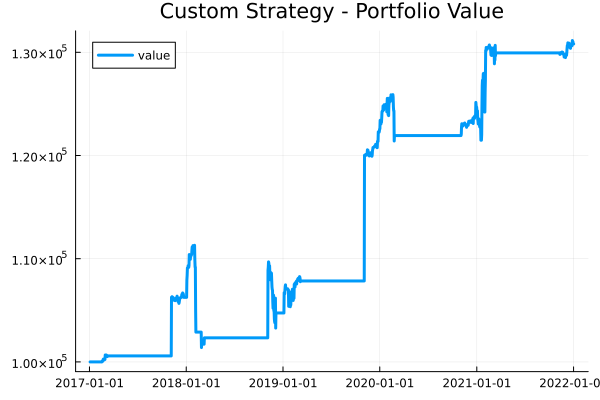

In [20]:
using AirBorne.Structures: summarizePerformance
using Plots: plot
results = summarizePerformance(dataA, custom_context)
plot(results.date, results.dollarValue, title="Custom Strategy - Portfolio Value", label="value", linewidth=3)